# 銷貨預測模型 LSTM

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, GRU
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import preprocessing, metrics
from sklearn.cluster import KMeans
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
# 設定dataframe在輸出時可以看到所有的欄位
pd.set_option('display.max_columns', None)
# 設定dataframe顯示到小數第四位
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# 設定print的輸出沒有科學記號
np.set_printoptions(suppress=True)

# 讀取資料集 (含內部、外部欄位)

In [3]:
data = pd.read_csv("no_lag_model_data.csv", index_col = 0)
data

,年/月,產品名稱,實銷貨量,含稅總成本,成本合計,銷貨淨額,淨利,贈送量,促銷量,0 <= 銷售單價 < 50,100 <= 銷售單價 < 150,1000以上,150 <= 銷售單價 < 200,200 <= 銷售單價 < 250,250 <= 銷售單價 < 300,300 <= 銷售單價 < 350,350 <= 銷售單價 < 400,400 <= 銷售單價 < 450,450 <= 銷售單價 < 500,50 <= 銷售單價 < 100,500 <= 銷售單價 < 550,550 <= 銷售單價 < 600,600 <= 銷售單價 < 650,650 <= 銷售單價 < 700,700 <= 銷售單價 < 750,750 <= 銷售單價 < 800,800 <= 銷售單價 < 850,850 <= 銷售單價 < 900,900 <= 銷售單價 < 950,950 <= 銷售單價 < 1000,北營所,台中所,宜蘭所,廠務部,營業一部,營業三部,營業五部,營業六部,營業四部,生管課,行銷部,高雄所,物價指數,食品、飲料及菸草製品零售業之營業額,這個月或下個月是否是春節,這個月或下個月是否是元宵節,這個月或下個月是否是清明節,這個月或下個月是否是端午節,這個月或下個月是否是中元節,這個月或下個月是否是中秋節,日正月營業額,01,02,03,04,05,06,07,08,09,10,11,12
0,2014/01,爆米花55g─甜,18226.0000,410418.3785,382414.4401,430513.3602,48099.6717,7.0000,5.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0884,0.1222,0.0162,-0.0019,0.0788,0.3767,0.0000,0.0395,0.0020,0.0000,0.0033,0.2748,98.2500,955,1,1,0,0,0,0,112678362.0000,1,0,0,0,0,0,0,0,0,0,0,0
1,2014/02,爆米花55g─甜,12680.0000,285319.0615,273962.0460,240240.3110,-33722.1366,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0674,0.0398,0.0148,0.0000,0.0568,0.6435,0.0000,0.0521,0.0000,0.0000,0.0040,0.1217,97.8700,754,1,1,0,0,0,0,56441949.0000,0,1,0,0,0,0,0,0,0,0,0,0
2,2014/03,爆米花55g─甜,9917.0000,223239.5520,211843.8057,232316.1090,20472.2427,0.0000,3.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1135,0.1417,0.0126,-0.0021,0.1209,0.3470,0.0000,0.0968,0.0121,0.0000,0.0015,0.1560,98.0500,852,0,0,1,0,0,0,79809422.0000,0,0,1,0,0,0,0,0,0,0,0,0
3,2014/04,爆米花55g─甜,15308.0000,345825.3050,324950.8142,362314.9976,37364.0808,56.0000,5.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0902,0.0800,0.0203,0.0000,0.1336,0.4254,0.0078,0.1176,0.0078,0.0000,0.0003,0.1171,98.7100,860,0,0,1,0,0,0,79008435.0000,0,0,0,1,0,0,0,0,0,0,0,0
4,2014/05,爆米花55g─甜,15141.0000,340857.8185,321210.6099,350201.7067,28990.8788,1.0000,6.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0926,0.0700,0.0213,-0.0005,0.1424,0.3790,0.0000,0.0159,0.0103,0.0000,0.0030,0.2660,98.8600,874,0,0,0,1,0,0,79113837.0000,0,0,0,0,1,0,0,0,0,0,0,0
5,2014/06,爆米花55g─甜,14118.0000,317721.3930,301280.3385,331215.9449,29935.4865,0.0000,2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1012,0.1264,0.0271,0.0017,0.1360,0.4092,0.0000,0.0170,0.0340,0.0000,0.0015,0.1459,99.3700,874,0,0,0,1,0,0,72858801.0000,0,0,0,0,0,1,0,0,0,0,0,0
6,2014/07,爆米花55g─甜,13815.0000,311056.5730,291408.2287,327844.6299,36436.0946,2.0000,7.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1046,0.0790,0.0299,0.0011,0.0867,0.4845,0.0000,0.0347,0.0000,0.0000,0.0025,0.1770,99.3400,959,0,0,0,0,1,0,96310048.0000,0,0,0,0,0,0,1,0,0,0,0,0
7,2014/08,爆米花55g─甜,53731.0000,1231506.6295,1093063.4239,1232532.6548,139469.0337,12.0000,987.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0705,0.3561,0.0311,0.0000,0.2094,0.1064,0.0000,0.0179,0.0000,0.0000,0.0018,0.2068,99.7700,925,0,0,0,0,1,1,90914885.0000,0,0,0,0,0,0,0,1,0,0,0,0
8,2014/09,爆米花55g─甜,22339.0000,506115.1490,471534.8460,497852.8182,26317.2882,42.0000,111.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0724,0.0905,0.0435,-0.0005,0.1025,0.3526,0.0000,0.0430,0.0000,0.0

In [4]:
data = data.drop(["生管課"], axis = 1)

### 不同的外部變數組合 
最佳組合 : 內部變數 + 零售業營業額 & 農曆節慶

In [5]:
# "物價指數", "食品、飲料及菸草製品零售業之營業額", "這個月或下個月是否是春節","這個月或下個月是否是元宵節", "這個月或下個月是否是清明節",
#                                 "這個月或下個月是否是端午節", "這個月或下個月是否是中元節", "這個月或下個月是否是中秋節"
data_without_outer = data.drop(["物價指數", "食品、飲料及菸草製品零售業之營業額", 
                                "這個月或下個月是否是春節","這個月或下個月是否是元宵節", "這個月或下個月是否是清明節",
                                "這個月或下個月是否是端午節", "這個月或下個月是否是中元節", "這個月或下個月是否是中秋節"], axis = 1)
data_with_price = data.drop(["食品、飲料及菸草製品零售業之營業額", 
                             "這個月或下個月是否是春節","這個月或下個月是否是元宵節", "這個月或下個月是否是清明節", 
                             "這個月或下個月是否是端午節", "這個月或下個月是否是中元節", "這個月或下個月是否是中秋節"], axis = 1)
data_with_retail = data.drop(["物價指數",
                              "這個月或下個月是否是春節","這個月或下個月是否是元宵節", "這個月或下個月是否是清明節", 
                             "這個月或下個月是否是端午節", "這個月或下個月是否是中元節", "這個月或下個月是否是中秋節"], axis = 1)
data_with_festival = data.drop(["物價指數", "食品、飲料及菸草製品零售業之營業額"], axis = 1)

data_with_price_retail = data.drop(["這個月或下個月是否是春節","這個月或下個月是否是元宵節", "這個月或下個月是否是清明節", 
                             "這個月或下個月是否是端午節", "這個月或下個月是否是中元節", "這個月或下個月是否是中秋節"], axis = 1)

data_with_price_festival = data.drop(["食品、飲料及菸草製品零售業之營業額"], axis = 1)

data_with_retail_festival = data.drop(["物價指數"], axis = 1)


In [193]:
#trian : 訓練資料集(dataframe)
train = data_with_retail_festival
train

,年/月,產品名稱,實銷貨量,含稅總成本,成本合計,銷貨淨額,淨利,贈送量,促銷量,0 <= 銷售單價 < 50,100 <= 銷售單價 < 150,1000以上,150 <= 銷售單價 < 200,200 <= 銷售單價 < 250,250 <= 銷售單價 < 300,300 <= 銷售單價 < 350,350 <= 銷售單價 < 400,400 <= 銷售單價 < 450,450 <= 銷售單價 < 500,50 <= 銷售單價 < 100,500 <= 銷售單價 < 550,550 <= 銷售單價 < 600,600 <= 銷售單價 < 650,650 <= 銷售單價 < 700,700 <= 銷售單價 < 750,750 <= 銷售單價 < 800,800 <= 銷售單價 < 850,850 <= 銷售單價 < 900,900 <= 銷售單價 < 950,950 <= 銷售單價 < 1000,北營所,台中所,宜蘭所,廠務部,營業一部,營業三部,營業五部,營業六部,營業四部,行銷部,高雄所,食品、飲料及菸草製品零售業之營業額,這個月或下個月是否是春節,這個月或下個月是否是元宵節,這個月或下個月是否是清明節,這個月或下個月是否是端午節,這個月或下個月是否是中元節,這個月或下個月是否是中秋節,日正月營業額,01,02,03,04,05,06,07,08,09,10,11,12
0,2014/01,爆米花55g─甜,18226.0000,410418.3785,382414.4401,430513.3602,48099.6717,7.0000,5.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0884,0.1222,0.0162,-0.0019,0.0788,0.3767,0.0000,0.0395,0.0020,0.0033,0.2748,955,1,1,0,0,0,0,112678362.0000,1,0,0,0,0,0,0,0,0,0,0,0
1,2014/02,爆米花55g─甜,12680.0000,285319.0615,273962.0460,240240.3110,-33722.1366,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0674,0.0398,0.0148,0.0000,0.0568,0.6435,0.0000,0.0521,0.0000,0.0040,0.1217,754,1,1,0,0,0,0,56441949.0000,0,1,0,0,0,0,0,0,0,0,0,0
2,2014/03,爆米花55g─甜,9917.0000,223239.5520,211843.8057,232316.1090,20472.2427,0.0000,3.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1135,0.1417,0.0126,-0.0021,0.1209,0.3470,0.0000,0.0968,0.0121,0.0015,0.1560,852,0,0,1,0,0,0,79809422.0000,0,0,1,0,0,0,0,0,0,0,0,0
3,2014/04,爆米花55g─甜,15308.0000,345825.3050,324950.8142,362314.9976,37364.0808,56.0000,5.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0902,0.0800,0.0203,0.0000,0.1336,0.4254,0.0078,0.1176,0.0078,0.0003,0.1171,860,0,0,1,0,0,0,79008435.0000,0,0,0,1,0,0,0,0,0,0,0,0
4,2014/05,爆米花55g─甜,15141.0000,340857.8185,321210.6099,350201.7067,28990.8788,1.0000,6.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0926,0.0700,0.0213,-0.0005,0.1424,0.3790,0.0000,0.0159,0.0103,0.0030,0.2660,874,0,0,0,1,0,0,79113837.0000,0,0,0,0,1,0,0,0,0,0,0,0
5,2014/06,爆米花55g─甜,14118.0000,317721.3930,301280.3385,331215.9449,29935.4865,0.0000,2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1012,0.1264,0.0271,0.0017,0.1360,0.4092,0.0000,0.0170,0.0340,0.0015,0.1459,874,0,0,0,1,0,0,72858801.0000,0,0,0,0,0,1,0,0,0,0,0,0
6,2014/07,爆米花55g─甜,13815.0000,311056.5730,291408.2287,327844.6299,36436.0946,2.0000,7.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1046,0.0790,0.0299,0.0011,0.0867,0.4845,0.0000,0.0347,0.0000,0.0025,0.1770,959,0,0,0,0,1,0,96310048.0000,0,0,0,0,0,0,1,0,0,0,0,0
7,2014/08,爆米花55g─甜,53731.0000,1231506.6295,1093063.4239,1232532.6548,139469.0337,12.0000,987.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0705,0.3561,0.0311,0.0000,0.2094,0.1064,0.0000,0.0179,0.0000,0.0018,0.2068,925,0,0,0,0,1,1,90914885.0000,0,0,0,0,0,0,0,1,0,0,0,0
8,2014/09,爆米花55g─甜,22339.0000,506115.1490,471534.8460,497852.8182,26317.2882,42.0000,111.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0724,0.0905,0.0435,-0.0005,0.1025,0.3526,0.0000,0.0430,0.0000,0.0022,0.2938,889,0,0,0,0,0,1,76731715.0000,0,0,0,0,0,0,0,0,1,0,0,0
9,2014/10,爆米花55g─甜,16001.0000,360160.5855,341183.9423,375435.873

In [194]:
# 超參數
PASTMONTH = 3         # 用過去幾周預測未來一周
INPUT_CELL_SIZE = 3        # 每一層中的隱藏神經元數
HIDDEN_CELL_SIZE = 3    # gru層(或LSTM層)的神經元數
BATCH_SIZE = 30000      # 訓練用的批量大小
LR = 0.1            # 學習率
N_SPLITS = 5          # 交叉驗證切分的組數
PATIENCE = 5          # 訓練時可容忍 監控的數值(目前採用VAL_LOSS)多少個EPOCH沒有改善
# 不可調參之參數
VARIABLE_NUM = 60

### Separate data by product name 

In [195]:
### Preparing the data ###
# 依產品名稱切割資料集(為了後續進行標準化及依時間做堆疊)

# product_stack_list 為包含不同產品的堆疊list(元素為dataframe)
# product_stack_list -- [df產品1, df產品2, ....]
# target_12 為包含不同產品的時銷貨量(Y) list(元素為numpy.ndarray)
# target_12 -- [numpy.ndarray產品實銷貨1, numpy.ndarray產品實銷貨2, ....]

print("Preparing the data ...")

product_stack_list = [None] * 7257
target_12 = [None] * 7257

for idx, p_name in enumerate(list(train["產品名稱"].unique())):
    # remeber to reset the index to make sure the Normalization can join the normlized data without NaN
    df = train[train["產品名稱"] == p_name].reset_index().drop(['index'], axis = 1)
    product_stack_list[idx] = df
    target_12[idx] = np.array(df['實銷貨量'][-1:])
    
print(len(product_stack_list)) # 應有7257

Preparing the data ...
7257


### Normalization (by Product)

In [197]:
# from numba import jit
# @jit
def normalize(train):
    """ 資料標準化(MinMax)
    
    將資料集中的數值型欄位(column -- 不同的變數組合有所不同)抽出，對其做MinMax Normalization後，再併入原資料集
    
    Args : 
        train : 單一產品的DataFrame (含1~48期、所有欄位)
        
    Returns : 
        train : 經過標準化後的DataFrame
        shipment_mean : 產品實銷貨量(Y)的最小值
        shipment_std : 產品實銷貨量(Y)的最大值減最小值
    """ 
    
    # 保留Y的平均值+標準差，之後轉回原始值會用到
    shipment_mean = np.min(train["實銷貨量"].head(47))
    shipment_std = np.max(train["實銷貨量"].head(47)) - np.min(train["實銷貨量"].head(47))
    
    # --------------------------------
    # 完整版
#     column = ["贈送量", "促銷量", "含稅總成本", "淨利", "成本合計", "銷貨淨額", "物價指數", 
#               "食品、飲料及菸草製品零售業之營業額", "日正月營業額", "實銷貨量"]
    # without_outer
#     column = ["贈送量", "促銷量", "含稅總成本", "淨利", "成本合計", "銷貨淨額", 
#               "日正月營業額", "實銷貨量"]
    # with_price
#     column = ["贈送量", "促銷量", "含稅總成本", "淨利", "成本合計", "銷貨淨額", "物價指數", 
#                "日正月營業額", "實銷貨量"]
    # with_retail
#     column = ["贈送量", "促銷量", "含稅總成本", "淨利", "成本合計", "銷貨淨額", 
#               "食品、飲料及菸草製品零售業之營業額", "日正月營業額", "實銷貨量"]
    # with_festival 和 without_outer一樣
#     column = ["贈送量", "促銷量", "含稅總成本", "淨利", "成本合計", "銷貨淨額",
#               "日正月營業額", "實銷貨量"]
    # with_price_retail
#     column = ["贈送量", "促銷量", "含稅總成本", "淨利", "成本合計", "銷貨淨額", "物價指數", 
#               "食品、飲料及菸草製品零售業之營業額", "日正月營業額", "實銷貨量"]
    # with_price_festival
#     column = ["贈送量", "促銷量", "含稅總成本", "淨利", "成本合計", "銷貨淨額", "物價指數", 
#                "日正月營業額", "實銷貨量"]
    # with_retail_festival
    column = ["贈送量", "促銷量", "含稅總成本", "淨利", "成本合計", "銷貨淨額", 
              "食品、飲料及菸草製品零售業之營業額", "日正月營業額", "實銷貨量"]
    # --------------------------------
    
    X = train[column]
    scaler = preprocessing.MinMaxScaler().fit(X.head(47))
    normX = scaler.transform(X)
    normX = pd.DataFrame(normX, columns = column)
#     print(type(normX)) >> <class 'numpy.ndarray'>
    
    train = train.drop(column, axis = 1)
    train = train.join(normX)
    
    return train, shipment_mean, shipment_std

In [198]:
### Normalization ###

# product_normalize_list 為不同產品資料標準化後list(元素為dataframe)
# product_normalize_list -- [df產品1, df產品2, ....](元素為numpy.ndarray)
# product_mean_list, product_std_list 為不同產品資料標準化後的 mean, std list(元素為dataframe)
# product_mean_list, product_std_list -- [numpy.ndarray產品mean1, numpy.ndarray產品mean2, ....], [numpy.ndarray產品std1, numpy.ndarray產品std2, ....]

product_normalize_list = [None] * 7257
product_mean_list = np.zeros((len(product_stack_list), 1))
product_std_list = np.zeros((len(product_stack_list), 1))

In [199]:
print("start")
tStart = time.time()#計時開始
idx = 0
for i in range (len(product_stack_list)):
    normalized, mean, std = normalize(product_stack_list[i])
    normalized.fillna(value=0, inplace=True) # 標準化後若是NA，全部改為0
    product_normalize_list[idx] = normalized
    product_mean_list[idx] = mean
    product_std_list[idx] = std
    idx = idx + 1

tEnd = time.time()#計時結束
print("end")
print("It costs %f sec" % (tEnd - tStart))

start


/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

end
It costs 26.974279 sec


/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/isvms/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with i

### Build data (stack) & split data(Training, Testing) 

In [200]:
def buildData(data, pastWeek=3, futureWeek=1):
    """ 資料堆疊
    
    將各產品的資料每三期作一個stack
    
    Args : 
        data : 單一產品的DataFrame (含1~48期、所有欄位)
        pastWeek : 每多少期作一個stack
        futureweek : 預測未來多久期數的實銷貨量
        
    Returns : 
        X : 經過堆疊後的產品資料(np.array)
        Y : 對應X的實銷貨量(np.array)
        
        X、Y為三維陣列 : (stack數量, PASTMONTH, 變數個數)
        
    Examples : 
        X : [(Jan., Feb., Mar.), (Feb., Mar., Apr.), ...]
        Y : [(May.實銷貨量),      (Jun.實銷貨量),      ...]
    """ 
    X = []
    Y = []
    
    for i in range(data.shape[0] - pastWeek - futureWeek):
        X.append(np.array(data[data.columns[2:]][i:i+pastWeek]))
        Y.append(np.array(data.iloc[i+pastWeek+1:i+pastWeek+futureWeek+1]["實銷貨量"]))
        
    return X, Y

In [201]:
### Stack ###

# X_train_list 為產品資料經過堆疊後的訓練集 list
# X_train_list -- [產品1[stack1, stack2, ...], 產品2[stack1, stack2, ...], ....]
# Y_train_list 為對應X的實銷貨量實際值 list
# X_test_list 為產品資料經過堆疊後的測試集 list

X_train_list = [None] * len(product_normalize_list)
Y_train_list = [None] * len(product_normalize_list)
X_test_list_12 = [None] * len(product_normalize_list)

In [202]:
# build Data stack, use last 3 weeks to predict next 1 week
print("start buildTrain")
tStart = time.time()

for idx, product in enumerate(product_normalize_list): #product_normalize_list 7257筆
    X, Y = buildData(product, PASTMONTH, 1)
    X_train_list[idx] = X[:-1]
    Y_train_list[idx] = Y[:-1]
    X_test_list_12[idx] = X[-1:]
    
tEnd = time.time()
print("end")
print("It costs %f sec" % (tEnd - tStart))

start buildTrain
end
It costs 263.289882 sec


### Reshape model data 

In [203]:
X_train_list = np.array(X_train_list)
Y_train_list = np.array(Y_train_list)
X_test_list_12 = np.array(X_test_list_12)

# print(X_train_list.shape) # (7257, 43, 3, 52)
# print(Y_train_list.shape) # (7257, 43, 1)
# print(X_test_list_12.shape) # (7257, 1, 3, 52)

In [204]:
### Reshape model data ###
nproducts, nsamples, nweeks, nx = X_train_list.shape # (7257, 43, 3, 52) > (7257 * 43, 3, 52)
X_train_list = X_train_list.reshape((nproducts * nsamples, nweeks, nx))
Y_train_list = Y_train_list.reshape((nproducts * nsamples, 1)) # (7257, 43, 1) > (7257 * 43, 1)
X_test_list_12 = X_test_list_12.reshape((nproducts * 1, nweeks, nx)) # (7257, 1, 3, 52) > (7257 * 1, 3, 52)
target_12 = np.array(target_12) # (7257, 1)

print(X_train_list.shape, Y_train_list.shape)
print(X_test_list_12.shape, target_12.shape)

(312051, 3, 59) (312051, 1)
(7257, 3, 59) (7257, 1)


# 建模(LSTM)

In [205]:
def buildManyToOneModel(shape):
    '''
    LSTM model
    
    Loss function : mse
    Optimizer : Adam
    '''
    model = Sequential()
    # Input Layer
    model.add(LSTM(INPUT_CELL_SIZE, input_length=shape[1], input_dim=shape[2]))
    # Hidden Layer
    model.add(Dense(HIDDEN_CELL_SIZE, activation='relu'))
    # Outout Layer > output shape: (1, 1)
    model.add(Dense(1))
    
    adam = optimizers.Adam(lr = LR, decay=1e-6, amsgrad=False)
    model.compile(loss="mse", optimizer=adam) # mean_absolute_percentage_error
    model.summary()
    return model

### Model (LSTM)

In [206]:
from keras import backend as K 
K.clear_session()
# del model

In [207]:
seed = 10
np.random.seed(seed)
# Cross Validation
kfold = KFold(n_splits = N_SPLITS, shuffle=False, random_state=seed)

### Training & Cross Validation

In [208]:
### Training ###
# Cross Validation
# 紀錄每次交叉驗證的 平均訓練誤差, 驗證誤差, model
# 選擇驗證誤差最小的模型作為預測模型
train_loss = [] 
cv_valid_loss = []
models = []

print("Training Start")
for train, valid in kfold.split(X_train_list, Y_train_list):
    model = buildManyToOneModel(X_train_list[train].shape)
    # 訓練集的loss不再減少即提前停止訓練
    # (監控 : loss, 接受10個epoch沒有improvement)
    callback = EarlyStopping(monitor = "val_loss", patience = PATIENCE, verbose=0, mode="min")
    #(X, Y, 每128個樣本數更新一次, , 顯示模式(0,1,2))
    history = model.fit(X_train_list[train], Y_train_list[train], 
                        validation_data=(X_train_list[valid], Y_train_list[valid]), 
                        batch_size = BATCH_SIZE, epochs=500, callbacks=[callback], verbose=0)
    valid_loss = model.evaluate(X_train_list[valid], Y_train_list[valid], verbose=0)
    print("valid loss:", valid_loss)
    
    train_loss.append(np.mean(history.history['loss']))
    cv_valid_loss.append(valid_loss)
    models.append(model)
print("average valid loss", np.mean(cv_valid_loss))

Training Start


/home/isvms/anaconda3/envs/intern_5/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # Remove the CWD from sys.path while we load stuff.
/home/isvms/anaconda3/envs/intern_5/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(3, input_shape=(3, 59))`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3)                 756       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 772
Trainable params: 772
Non-trainable params: 0
_________________________________________________________________
valid loss: 0.07439282258191009
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3)                 756       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 12        
______________________________________________

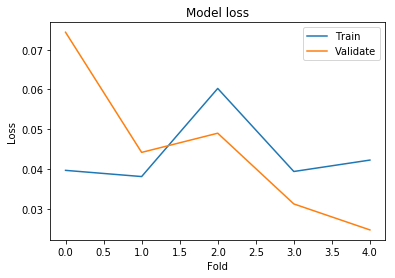

In [209]:
# 繪製訓練 & 驗證的損失值
plt.plot(train_loss)
plt.plot(cv_valid_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Fold')
plt.legend(['Train', 'Validate'], loc='upper right')
plt.show()

### Testing

In [210]:
### Testing ###
# 選擇驗證誤差最小的模型作為預測模型
idx = np.argmin(cv_valid_loss)
model = models[idx]

print("最終預測結果展示 : ")
loss = model.evaluate(X_test_list_12, target_12)
print("Loss (December) : %.2f" % (loss))

### predict ###
# 預測值
Y_pred_12 = model.predict(X_test_list_12)
# 實際值
Y_real_12 = target_12

# 還原預測值
for i in range(len(product_mean_list)):
    Y_pred_12[i] = Y_pred_12[i] * product_std_list[i] + product_mean_list[i]

最終預測結果展示 : 
7257/7257 [==============================] - 1s 109us/step
Loss (December) : 5294166.47


## Result analysis

In [211]:
# 將預測結果轉換成DataFrame & 計算 APE, SE

Y_pred_12 = pd.DataFrame(Y_pred_12)
Y_pred_12['real'] = Y_real_12
Y_pred_12.columns = ['pred', 'real']

# Adjusted real 避免MAPE無限大
# real 0~1 轉成 1; -1~0 轉成 -1
Y_pred_12.loc[(Y_pred_12['real'] > -1) & (Y_pred_12['real'] < 0), 'real'] = -1
Y_pred_12.loc[(Y_pred_12['real'] <  1) & (Y_pred_12['real'] >=0), 'real'] = 1
# mape
Y_pred_12['mape'] = np.abs((Y_pred_12['pred'] - Y_pred_12['real']) / Y_pred_12['real']) * 100
# mse
Y_pred_12['mse'] = (Y_pred_12['pred'] - Y_pred_12['real']) ** 2

Y_pred_12

,pred,real,mape,mse
0,33005.6133,7054.0000,367.8993,673486231.8996
1,11830.3545,28320.0000,58.2261,271908408.9733
2,748.6286,1.0000,74762.8601,558948.5251
3,7542.6992,9030.0000,16.4707,2212063.6139
4,596.5447,1.0000,59554.4739,354673.5359
5,-1.8239,1.0000,282.3921,7.9745
6,19518.3477,1575.0000,1139.2602,321963725.1131
7,4411.7925,3001.0000,47.0107,1990335.4229
8,1762.5679,2012.0000,12.3972,62216.3869
9,11.3008,1.0000,1030.0827,106.1070


##### MAPE

In [212]:
print(Y_pred_12['mape'].mean())
Y_pred_12.sort_values(by = ['mape'], ascending = True)

3805.796887212957


,pred,real,mape,mse
880,624.9030,627.0000,0.3344,4.3973
256,229.9377,231.0000,0.4599,1.1285
237,8269.1602,8310.0000,0.4915,1667.8928
4893,2912.5652,2930.0000,0.5950,303.9728
219,5376.3877,5338.0000,0.7191,1473.6152
1142,0.9908,1.0000,0.9174,0.0001
477,1.0100,1.0000,0.9977,0.0001
622,24433.8535,24000.0000,1.8077,188228.8730
386,1798.9626,1767.0000,1.8089,1021.6108
228,16996.9922,17320.0000,1.8649,104334.0469


##### MSE 

In [213]:
print(Y_pred_12['mse'].mean())
Y_pred_12.sort_values(by = ['mse'], ascending = True)

2906503.291839008


,pred,real,mape,mse
1142,0.9908,1.0000,0.9174,0.0001
477,1.0100,1.0000,0.9977,0.0001
884,1.0203,1.0000,2.0331,0.0004
4704,1.0203,1.0000,2.0331,0.0004
6618,1.0203,1.0000,2.0331,0.0004
6404,1.0203,1.0000,2.0331,0.0004
4585,1.0203,1.0000,2.0331,0.0004
4186,1.0203,1.0000,2.0331,0.0004
5842,1.0203,1.0000,2.0331,0.0004
6652,1.0203,1.0000,2.0331,0.0004


##### Visualization 

In [214]:
def plotScatter(full_stat):
    """ 繪製散佈圖
    
    將預測結果的DataFrame依mape由小至大排列，呈現mape在不同比例下，實際值與預測值的散佈圖
    
    Args : 
        full_stat : 預測結果的DataFrame，含 pred, real, mape, mse 欄位
    """
    
    full_stat = full_stat.sort_values(by = ['mape'], ascending = True)
    
    print("full stat")
    min_scale = min(full_stat['pred'].min(), 
                    full_stat['real'].min())
    max_scale = max(full_stat['pred'].max(), 
                    full_stat['real'].max())
    plt.scatter(full_stat['pred'], full_stat['real'])
    x = np.linspace(min_scale, max_scale)
    y = x
    plt.plot(x, y, '-r')
    plt.title('Y-hat vs. Y')
    plt.ylabel('Real')
    plt.xlabel('Pred')
    plt.show()

    # plot 10%
    min_scale = min(full_stat['pred'].iloc[0:(round(len(full_stat)*0.10))].min(), 
                    full_stat['real'].iloc[0:(round(len(full_stat)*0.10))].min())
    max_scale = max(full_stat['pred'].iloc[0:(round(len(full_stat)*0.10))].max(), 
                    full_stat['real'].iloc[0:(round(len(full_stat)*0.10))].max())
    plt.scatter(full_stat['pred'].iloc[0:(round(len(full_stat)*0.10))], 
                full_stat['real'].iloc[0:(round(len(full_stat)*0.10))])
    x = np.linspace(min_scale, max_scale)
    y = x
    plt.plot(x, y, '-r')
    plt.title('Y-hat vs. Y (10%)')
    plt.ylabel('Real')
    plt.xlabel('Pred')
    plt.show()
    
    # plot 10% ~ 20%
    min_scale = min(full_stat['pred'].iloc[(round(len(full_stat)*0.10)) : (round(len(full_stat)*0.20))].min(), 
                    full_stat['real'].iloc[(round(len(full_stat)*0.10)) : (round(len(full_stat)*0.20))].min())
    max_scale = max(full_stat['pred'].iloc[(round(len(full_stat)*0.10)) : (round(len(full_stat)*0.20))].max(), 
                    full_stat['real'].iloc[(round(len(full_stat)*0.10)) : (round(len(full_stat)*0.20))].max())
    plt.scatter(full_stat['pred'].iloc[(round(len(full_stat)*0.10)) : (round(len(full_stat)*0.20))], 
                full_stat['real'].iloc[(round(len(full_stat)*0.10)) : (round(len(full_stat)*0.20))])
    x = np.linspace(min_scale, max_scale)
    y = x
    plt.plot(x, y, '-r')
    plt.title('Y-hat vs. Y (10% ~ 20%)')
    plt.ylabel('Real')
    plt.xlabel('Pred')
    plt.show()
    
    # plot 20% ~ 50%
    min_scale = min(full_stat['pred'].iloc[(round(len(full_stat)*0.20)) : (round(len(full_stat)*0.50))].min(), 
                    full_stat['real'].iloc[(round(len(full_stat)*0.20)) : (round(len(full_stat)*0.50))].min())
    max_scale = max(full_stat['pred'].iloc[(round(len(full_stat)*0.20)) : (round(len(full_stat)*0.50))].max(), 
                    full_stat['real'].iloc[(round(len(full_stat)*0.20)) : (round(len(full_stat)*0.50))].max())
    plt.scatter(full_stat['pred'].iloc[(round(len(full_stat)*0.20)) : (round(len(full_stat)*0.50))], 
                full_stat['real'].iloc[(round(len(full_stat)*0.20)) : (round(len(full_stat)*0.50))])
    x = np.linspace(min_scale, max_scale)
    y = x
    plt.plot(x, y, '-r')
    plt.title('Y-hat vs. Y (20% ~ 50%)')
    plt.ylabel('Real')
    plt.xlabel('Pred')
    plt.show()
    
    # plot 50% ~ 75%
    min_scale = min(full_stat['pred'].iloc[(round(len(full_stat)*0.50)) : (round(len(full_stat)*0.75))].min(), 
                    full_stat['real'].iloc[(round(len(full_stat)*0.50)) : (round(len(full_stat)*0.75))].min())
    max_scale = max(full_stat['pred'].iloc[(round(len(full_stat)*0.50)) : (round(len(full_stat)*0.75))].max(), 
                    full_stat['real'].iloc[(round(len(full_stat)*0.50)) : (round(len(full_stat)*0.75))].max())
    plt.scatter(full_stat['pred'].iloc[(round(len(full_stat)*0.50)) : (round(len(full_stat)*0.75))], 
                full_stat['real'].iloc[(round(len(full_stat)*0.50)) : (round(len(full_stat)*0.75))])
    x = np.linspace(min_scale, max_scale)
    y = x
    plt.plot(x, y, '-r')
    plt.title('Y-hat vs. Y (50% ~ 75%)')
    plt.ylabel('Real')
    plt.xlabel('Pred')
    plt.show()

    # plot 75% ~ 100%
    min_scale = min(full_stat['pred'].iloc[(round(len(full_stat)*0.75)) :].min(), 
                    full_stat['real'].iloc[(round(len(full_stat)*0.75)) :].min())
    max_scale = max(full_stat['pred'].iloc[(round(len(full_stat)*0.75)) :].max(), 
                    full_stat['real'].iloc[(round(len(full_stat)*0.75)) :].max())
    plt.scatter(full_stat['pred'].iloc[(round(len(full_stat)*0.75)) :], 
                full_stat['real'].iloc[(round(len(full_stat)*0.75)) :])
    x = np.linspace(min_scale, max_scale)
    y = x
    plt.plot(x, y, '-r')
    plt.title('Y-hat vs. Y (75% ~ 100%)')
    plt.ylabel('Real')
    plt.xlabel('Pred')
    plt.show()

full stat


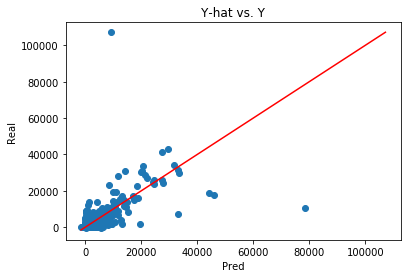

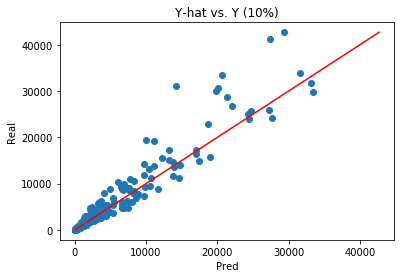

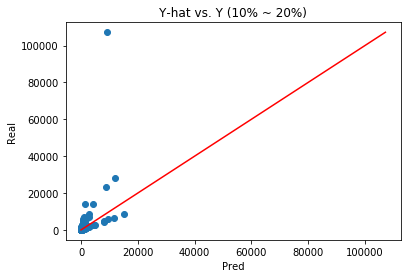

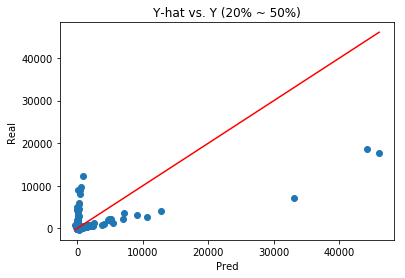

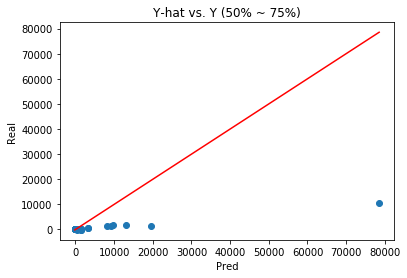

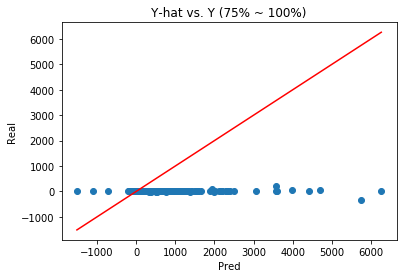

In [215]:
plotScatter(Y_pred_12)

In [216]:
def freqplot(stat):
    """ 繪製MAPE次數分配圖
    
    繪製預測結果DataFrame的mape之次數分配圖
    
    Args : 
        stat : 預測結果的DataFrame，含 pred, real, mape, mse 欄位
    """
    
    data = [stat.loc[(stat['mape'] > 0) & (stat['mape'] <= 5000)].count()[0] / len(stat), 
            stat.loc[(stat['mape'] > 5000) & (stat['mape'] <= 10000)].count()[0] / len(stat), 
            stat.loc[(stat['mape'] > 10000) & (stat['mape'] <= 15000)].count()[0] / len(stat), 
            stat.loc[(stat['mape'] > 15000) & (stat['mape'] <= 20000)].count()[0] / len(stat), 
            stat.loc[(stat['mape'] > 20000)].count()[0] / len(stat)]
    
    ax = pd.Series(data).plot.bar(figsize = (15, 7),fontsize = 16)
    ax.set_title('Frequency distribution of MAPE', fontsize = 20)
    ax.set_xticklabels(['0~5000', '5000~10000', '10000~15000', '15000~20000', '>20000'])
    ax.set_xlabel('MAPE', fontsize = 16)
    ax.set_ylabel('Frequency', fontsize = 16)
    plt.xticks(rotation = 0)
    for i, v in enumerate(data):
        ax.text(i, v, round(v, 2), horizontalalignment='center', fontsize = 16)

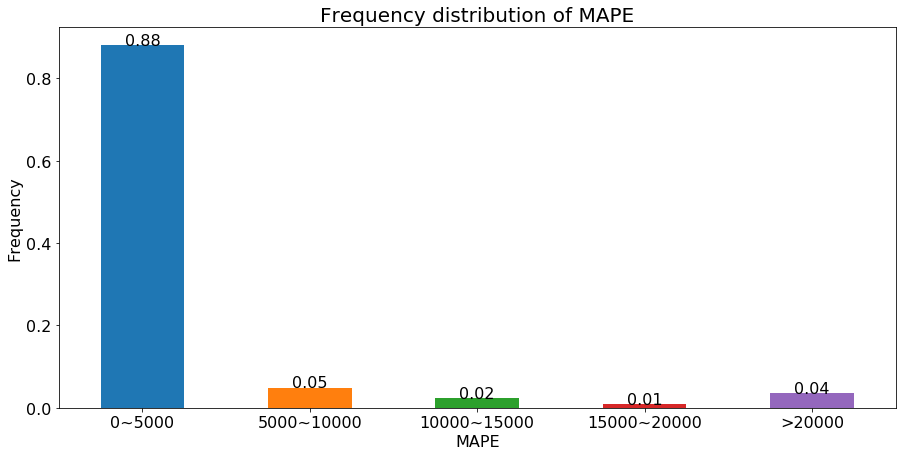

In [217]:
freqplot(Y_pred_12)

##### Performance 

In [218]:
def calPerformance(full_stat):
    """ 預測表現以DataFrame呈現
    
    將預測結果的DataFrame依mape由小至大排列，呈現預測結果在不同ape比例下之MAPE及整體之MSE
    
    Args : 
        full_stat : 預測結果的DataFrame，含 pred, real, mape, mse 欄位
        
    Returns :
        data : 預測表現之DataFrame
    """
    
    full_stat = full_stat.sort_values(by = ['mape'], ascending = True)
    
    # 計算測試集整體資料的MAPE，以及誤差排序後最低的75%、50%、20%、10%資料的MAPE
    mape_all = full_stat['mape'].mean()
    mape_75 = full_stat['mape'].iloc[0:(round(len(full_stat)*0.75))].mean()
    mape_50 = full_stat['mape'].iloc[0:(round(len(full_stat)*0.50))].mean()
    mape_20 = full_stat['mape'].iloc[0:(round(len(full_stat)*0.20))].mean()
    mape_10 = full_stat['mape'].iloc[0:(round(len(full_stat)*0.10))].mean()
    mse = full_stat['mse'].mean()
    data = [mape_all, mape_75, mape_50, mape_20, mape_10, mse]
    data = pd.DataFrame([data], columns = ['整體資料的MAPE', '誤差排序後最低的75%資料的MAPE', '誤差排序後最低的50%資料的MAPE', 
                                      '誤差排序後最低的20%資料的MAPE', '誤差排序後最低的10%資料的MAPE', '整體資料的MSE'])
    return data

In [219]:
calPerformance(Y_pred_12)

,整體資料的MAPE,誤差排序後最低的75%資料的MAPE,誤差排序後最低的50%資料的MAPE,誤差排序後最低的20%資料的MAPE,誤差排序後最低的10%資料的MAPE,整體資料的MSE
0,3805.7969,355.3944,134.0325,54.6444,28.5452,2906503.2918


# Model End

In [32]:
np.max(X_test_list_12)

9.5